In [24]:
import flopy
import numpy as np
import matplotlib.pyplot as plt
import shutil
from pathlib import Path
import os
from datetime import datetime

from tempfile import TemporaryDirectory
from tempfile import mkdtemp

import os
import platform
import subprocess

In [84]:

# Define model workspace

myt = datetime.now().strftime('%m%d%H%M%S')
name = 'wasaga'
temp_dir = mkdtemp(prefix='_T{}_{}_'.format(myt,name))
os.makedirs(Path(temp_dir) / '_output')

#model_ws = "./modflow_model_2"
model_ws = temp_dir

def open_file(path):
    if platform.system() == "Windows":
        os.startfile(path)
    elif platform.system() == "Darwin":
        subprocess.Popen(["open", path])
    else:
        subprocess.Popen(["xdg-open", path])

open_file(model_ws)





In [85]:
# Create a MODFLOW model instance
model = flopy.seawat.Seawat(modelname="example_model", model_ws=model_ws, exe_name="swtv4")


In [86]:
# Define model dimensions
nlay = 50
nrow = 190
ncol = 220
delr = 12.0  # Cell width along rows (extend 2200 / 220)
delc = 12.0  # Cell width along columns (extend 1900 / 190)

# Define top elevation
top_elev = 190.0

# Define layer thickness (uniform thickness)
layer_thickness = 25.0 / nlay

perlen = 365
nper = 70
nstp = np.repeat(1,nper)
steady = np.append(np.array([True]),np.repeat(False,nper-1))

# Create DIS package
dis = flopy.modflow.ModflowDis(model, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr, delc=delc,top=top_elev, 
                               botm=[top_elev - (i * layer_thickness) for i in range(1, nlay + 1)],
                               nper = nper,
                               perlen = perlen,
                               nstp = nstp,
                               steady = steady)



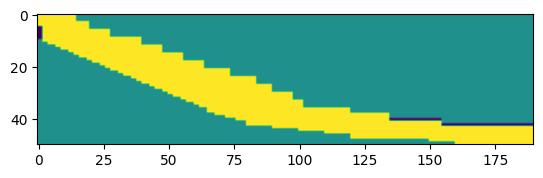

In [87]:



# Define ibound and initial conditionsa
ibound = np.ones((nlay, nrow, ncol), dtype=int)

# Set constant head boundary conditions for the first and last rows




# Change the values in the top left corner to 1s
ibound[:3, 15:,:] = 0
ibound[3:6, 20:,:] = 0
ibound[6:9, 28:,:] = 0
ibound[9:12, 40:,:] = 0
ibound[12:15, 48:,:] = 0
ibound[15:18, 56:,:] = 0
ibound[18:21, 64:,:] = 0
ibound[21:24, 74:,:] = 0
ibound[24:27, 84:,:] = 0
ibound[27:30, 90:,:] = 0
ibound[30:33, 98:,:] = 0
ibound[33:36, 102:,:] = 0
ibound[36:38, 120:,:] = 0
ibound[38:40, 135:,:] = 0
ibound[40:42, 155:,:] = 0

ibound[40, 135:155,:] = -1
ibound[42, 155:,:] = -1





rows  = ([160]+[150] + [120]  + 
         list(np.linspace(120,80,5).astype(int)) + 
         list(np.linspace(80,65,5).astype(int)) + 
         list(np.linspace(65,0,28).astype(int)))
for layer in range(40):
    row = rows[layer]
    ibound[49-layer,:row,:]= 0


#ibound[45:-1, 180:,:] = 0



ibound[5:10, 0:2, :] = -1  # Constant head for the first row
#ibound[:, -1, :] = -1  # Constant head for the last row


plt.imshow(ibound[:,:,2])



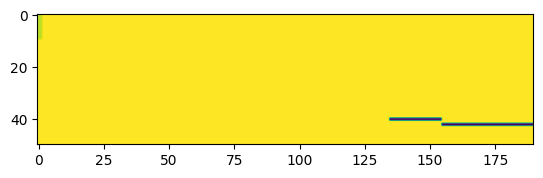

In [88]:
# Define initial head conditions
initial_head = np.full((nlay, nrow, ncol),190.0, dtype=float)
initial_head[:10, 0:2, :] = 188.0  # Initial head for the first row
#initial_head[:, -1, :] = 178.0  # Initial head for the last row
initial_head[40, 135:155,:] = 170.0
initial_head[42, 155:,:] = 170.0

plt.imshow(initial_head[:,:,3])
#plt.colorbar()

In [89]:

# Create BAS package
bas = flopy.modflow.ModflowBas(model, ibound=ibound, strt=initial_head)

# Define hydraulic properties
horizontal_k = 6.9  # Horizontal hydraulic conductivity (m/day)
vertical_k = 0.1   # Vertical hydraulic conductivity (m/day)
porosity = 0.25     # Porosity

# Create LPF package (Layer Property Flow package)
lpf = flopy.modflow.ModflowLpf(model, hk=horizontal_k, vka=vertical_k, laytyp=1, ipakcb=53,ss=0.0002,sy=0.33)



pcg = flopy.modflow.ModflowPcg(model, hclose=1e-3)


# Create a steady-state MODFLOW model
# You can add additional packages and settings as needed for your specific problem


# OC - Output Control Option
oc = flopy.modflow.ModflowOc(
    model,
    stress_period_data= None,
    compact=True,
)


In [90]:
wel_data = {}
wel_data[1] = [[28,75,20,0.075]]
wel_data[2] = [[28,75,20,0.075],[26,65,60,0.075]]
wel_data[3] = [[28,75,20,0.000],[26,65,60,0.075]]
wel_data[4] = [[28,75,20,0.000],[26,65,60,0.000]]

#stress_period_data = {0: [[lay, row, col, flux], [lay, row, col, flux], [lay, row, col, flux] ],

wel = flopy.modflow.ModflowWel(model, stress_period_data=wel_data, ipakcb=53)

In [91]:
icbund = ibound.copy()

btn = flopy.mt3d.Mt3dBtn(
    model,
    nprs=5,
    timprs=np.cumsum([200]*7),
    prsity=0.25,
    sconc= 0., # starting concentration
    ifmtcn=0, chkmas=False, nprobs=10, nprmas=10,
    dt0=5,  # The user-specified initial 
    ttsmult=1.5,
    mxstrn = 50000,
    icbund = icbund
)


In [92]:
adv = flopy.mt3d.Mt3dAdv(model, mixelm=0,percel=0.4,mxpart=200000,nadvfd=0)
dsp = flopy.mt3d.Mt3dDsp(model, al=0.2, trpt=0.1, 
                        trpv=0.1, 
                        dmcoef=3.7E-10 )
gcg = flopy.mt3d.Mt3dGcg(model, iter1=50, mxiter=1, isolve=2, cclose= 1e-5)

In [93]:
# ## SSM
ssm_data = {}
itype = flopy.mt3d.Mt3dSsm.itype_dict()
ssm_data[1] = [(28,75,20, 3000.0, itype['WEL'])]
ssm_data[2] = [(28,75,20, 3000.0, itype['WEL']),(26,65,60,3000, itype['WEL'])]
ssm_data[3] = [(28,75,20, 0, itype['WEL']),(26,65,60,3000, itype['WEL'])]
ssm_data[4] = [(28,75,20, 0, itype['WEL']),(26,65,60,0, itype['WEL'])]

ssm = flopy.mt3d.Mt3dSsm(model, stress_period_data=ssm_data)

In [211]:
## RCT

rct = flopy.mt3d.Mt3dRct(model=model, isothm=3,sp1=0.00001,sp2=0.0001,igetsc=0,rhob= 1.65E+09)

In [255]:
rch = flopy.modflow.ModflowRch(model = model, rech = 0.0041)

In [256]:

# Write MODFLOW input files
model.write_input()


In [257]:

# Run the MODFLOW model
model.run_model()


FloPy is using the following executable to run the model: C:\Users\swan47\AppData\Local\flopy\bin\swtv4.EXE

                                  SEAWAT Version 4
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 4.00.05 10/19/2012                      

Incorporated MODFLOW Version: 1.18.01 06/20/2008                      
Incorporated MT3DMS  Version: 5.20    10/30/2006                      


 This program is public domain and is released on the
 condition that neither the U.S. Geological Survey nor
 the United States Government may be held liable for any
 damages resulting from their authorized or unauthorized
 use.


 Using NAME file: example_model.nam                                                                                                                                                                                       
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/09/13 19:06:18


 STRESS PERIOD NO.  

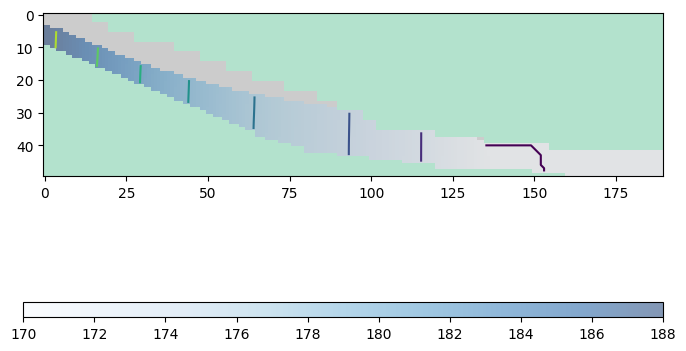

In [246]:
# Import necessary libraries for plotting
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

budobj = bf.HeadFile(model_ws + '/example_model.hds')
times = budobj.get_times()
head = budobj.get_data(totim=times[2])
# Assuming 'head', 'ibound' are defined somewhere in your code

arr = head[:, :, 20].copy()
arr[arr < 0] = np.nan

topo = ibound[:, :, 0].copy()
topo[topo == -1] = 1



# Create a 2x1 grid of subplots
fig,ax1 = plt.subplots(figsize=(8,5))
#fig.figure()

# Plot 'topo' in the first subplot
ax1.imshow(topo, cmap='Pastel2')

# Plot 'arr' in the second subplot
im = ax1.imshow(arr,alpha=0.5,cmap='Blues')
c = ax1.contour(arr)

# Create a colorbar at the bottom
cax = fig.add_axes([0.1, 0.05, 0.8, 0.03])  # [left, bottom, width, height]
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')



# Show the plots
plt.show()

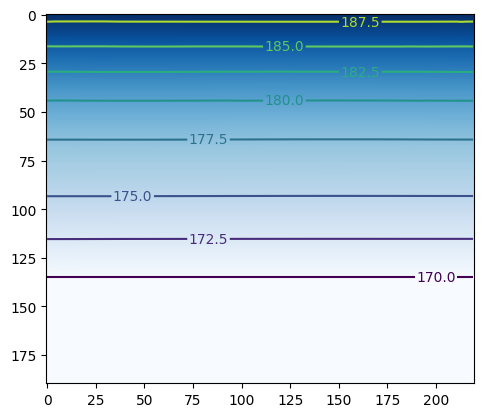

In [251]:


budobj = bf.HeadFile(model_ws + '/example_model.hds')
times = budobj.get_times()
head = budobj.get_data(totim=times[1])
head[head<0]=np.nan

topview = head[0].copy()
for n in range(head.shape[0]):
    layer = head[n]
    topview[np.isnan(topview)] = layer[np.isnan(topview)]

# add contour to the plot
fig, ax = plt.subplots()
c = ax.contour(topview)
ax.clabel(c, inline=True, fontsize=10)
plt.imshow(topview,cmap='Blues')
plt.show()

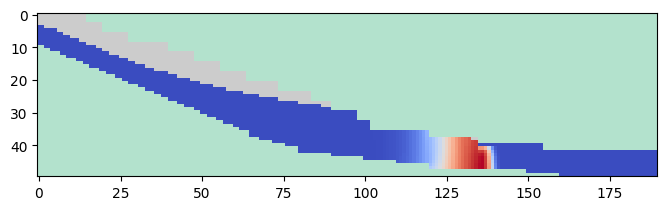

In [216]:
ucnobj = bf.UcnFile(model_ws + '/MT3D001.UCN', model=model)
times = ucnobj.get_times()
conc = ucnobj.get_data(totim=times[-1])
arr = conc[:, :, 20].copy()
arr[arr==1.e+30] = np.nan


# Create a 2x1 grid of subplots
fig,ax1 = plt.subplots(figsize=(8,5))
#fig.figure()

# Plot 'topo' in the first subplot
ax1.imshow(topo, cmap='Pastel2')

# Plot 'arr' in the second subplot
im = ax1.imshow(arr,cmap='coolwarm')


In [217]:
times 

[200.0,
 365.0,
 400.0,
 600.0,
 730.0,
 800.0,
 1000.0,
 1095.0,
 1200.0,
 1400.0,
 1460.0,
 1825.0,
 2190.0,
 2555.0,
 2920.0,
 3285.0,
 3650.0,
 4015.0,
 4380.0,
 4745.0,
 5110.0,
 5475.0,
 5840.0,
 6205.0,
 6570.0,
 6935.0,
 7300.0,
 7665.0,
 8030.0,
 8395.0,
 8760.0,
 9125.0,
 9490.0,
 9855.0,
 10220.0,
 10585.0,
 10950.0,
 11315.0,
 11680.0,
 12045.0,
 12410.0,
 12775.0,
 13140.0,
 13505.0,
 13870.0,
 14235.0,
 14600.0,
 14965.0,
 15330.0,
 15695.0,
 16060.0,
 16425.0,
 16790.0,
 17155.0,
 17520.0,
 17885.0,
 18250.0,
 18615.0,
 18980.0,
 19345.0,
 19710.0,
 20075.0,
 20440.0,
 20805.0,
 21170.0,
 21535.0,
 21900.0,
 22265.0,
 22630.0,
 22995.0,
 23360.0,
 23725.0,
 24090.0,
 24455.0,
 24820.0,
 25185.0,
 25550.0]

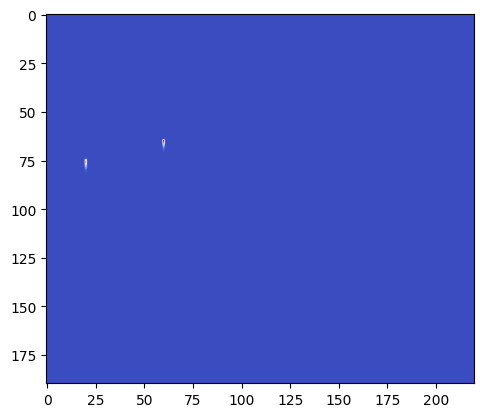

In [218]:
budobj = bf.UcnFile(model_ws + '/MT3D001.UCN', model=model)
times = budobj.get_times()
conc = budobj.get_data(totim=times[10])
conc[conc==1.e+30]=np.nan


topview = conc[0].copy()
for n in range(conc.shape[0]):
    #print(n)
    layer = conc[n]
    topview[np.isnan(topview)] = layer[np.isnan(topview)]


plt.imshow(topview,cmap='coolwarm')

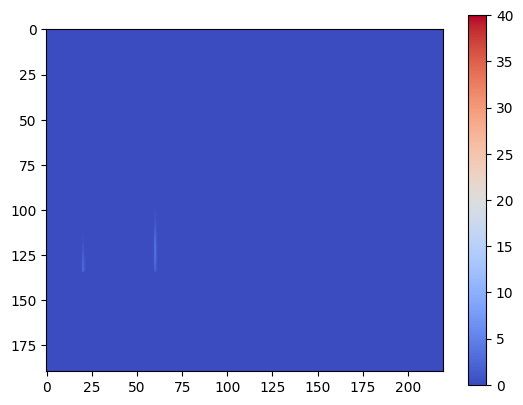

In [219]:
budobj = bf.UcnFile(model_ws + '/MT3D001.UCN', model=model)
times = budobj.get_times()
conc = budobj.get_data(totim=times[-1])
conc[conc==1.e+30]=np.nan


topview = conc[0].copy()
for n in range(conc.shape[0]):
    #print(n)
    layer = conc[n]
    topview[np.isnan(topview)] = layer[np.isnan(topview)]

plt.imshow(topview,cmap='coolwarm',vmin=0,vmax=40)

plt.colorbar()

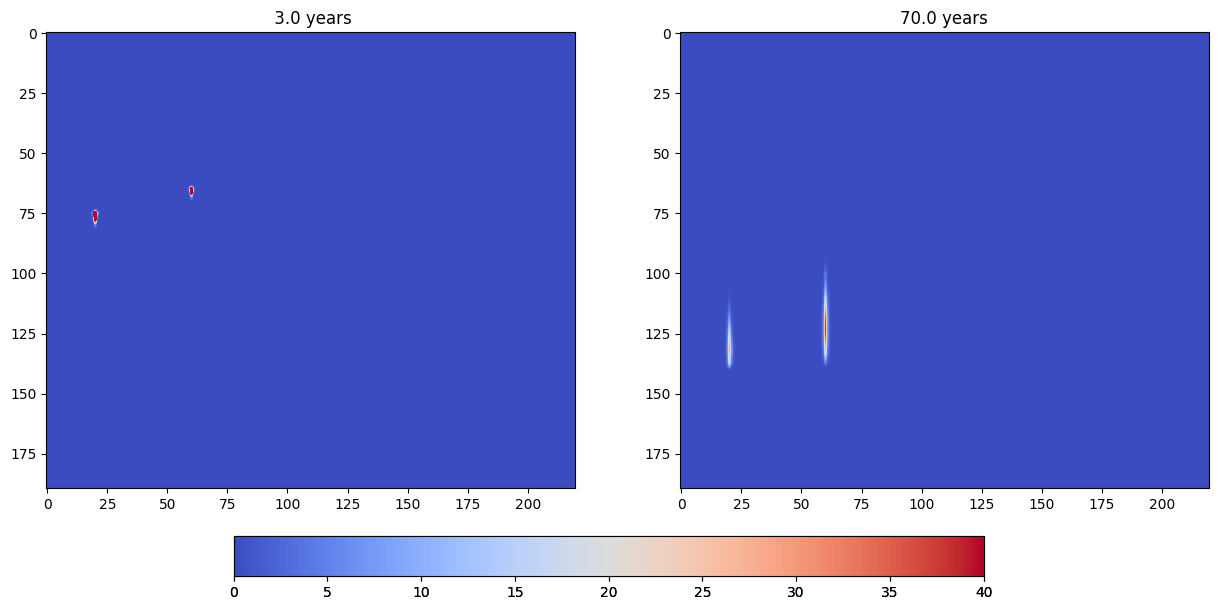

In [254]:
fig, axes = plt.subplots(1, 2)

budobj = bf.UcnFile(model_ws + '/MT3D001.UCN', model=model)
times = budobj.get_times()

conc = budobj.get_data(totim=times[7])
conc[conc==1.e+30]=0

ax = axes[0]
im1 = ax.imshow(np.sum(conc,axis=0),cmap='coolwarm',vmin=0,vmax=40)
cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.05])
fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
ax.set_title(' {:.1f} years'.format(times[7]/365))

conc = budobj.get_data(totim=times[-1])
conc[conc==1.e+30]=0
ax = axes[1]
im2 = ax.imshow(np.sum(conc,axis=0),cmap='coolwarm',vmin=0,vmax=40)
cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.05])
fig.colorbar(im2, cax=cbar_ax, orientation='horizontal')
ax.set_title('{:.1f} years'.format(times[-1]/365))

fig.set_size_inches(15,8)